# COMPUTER VISION - PA2

# Name: Rohan Vardhan
# PID: 4177660

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [2]:
#############################################################
##                                                         ##
##     PROBLEM 1: LUCAS-KANADE OPTICAL FLOW ESTIMATION     ##
##                                                         ##
#############################################################

In [3]:
from __future__ import division
from multiprocessing import Queue
from imaplib import _Authenticator
from sys import  argv
from PIL import Image
from PIL import ImageChops as ic
#from pylab import *
import matplotlib.pyplot as plt
import numpy as np
from  scipy.ndimage import filters
from scipy import misc
from scipy import  signal
import math
from numpy.linalg import inv
import copy as cp
from numpy.linalg import inv
from scipy import interpolate
import cv2

Below program will compute Optical flow in pair of image pairs as below steps:<br\>

1) we compute harris corners of one image uisnsg goodfeatures to track.It will give the list of harris corners.<br\>
2) we compute gradient of image and dt using temporal difference between 2 images. <br\>
3) we run a 5x5 window around each harris corner and compute  sum of fx*fx   fy*fy  and fxfy ,fxft and fyft values in each of the window and we get A = [[fx*fx;fxfy][fy*fx;fyfy]] and B = [fxft fyft]transpose and perform (inv(A))*(-B) on each pixel and we get [u v]transpose. <br\>
4)we plot [u v] on the both image pairs using plt.arrow funtion. <br\>

params selection  for  corner detection like no of corners , threshold value and mindistance between corners and size of filter block that is passed in computing corners

In [4]:
feature_params = dict( maxCorners = 500,qualityLevel = 0.02,minDistance = 7,blockSize = 7)

In [5]:
def calcLK(Image2,A,B,halfwindow,alpha=0.001):
    """
    below funtion will compuete optical flow of the image and return the flow vector
    """
    
    B_original = np.zeros(B.shape)
    B_original[:] = B

    #u,v matrixes for storing flow
    u = np.zeros((A.shape[0],A.shape[1]),dtype=np.float32)
    v = np.zeros((A.shape[0],A.shape[1]),dtype=np.float32)


    #Lucas Kanade step will be perfomed for 5 iterations and flow of ach iteration is added to the original flow
    for iter in range(0,5):


        Apad = np.zeros((A.shape[0]+2*halfwindow,A.shape[1]+2*halfwindow),dtype = np.float32)
        Bpad = np.zeros((B.shape[0]+2*halfwindow,B.shape[1]+2*halfwindow),dtype = np.float32)



        Ix = np.zeros((B.shape[0]+2*halfwindow,B.shape[1]+2*halfwindow))
        Iy = np.zeros((B.shape[0]+2*halfwindow,B.shape[1]+2*halfwindow))
        It = np.zeros((B.shape[0]+2*halfwindow,B.shape[1]+2*halfwindow))

        #if for second iteration we adjust the image based on intial flow vectors
        if iter >0:
            B[:] = cv2.remap(B_original,u,v,cv2.INTER_CUBIC)

        #both images are padded
        Apad[:] = np.pad(A,halfwindow,mode='reflect')
        Bpad[:] = np.pad(B,halfwindow,mode='reflect')


        # kernelx = np.array([[-1.0,1.0],[-1.0,1.0]] ,np.float32) # kernel should be floating point type.
        # kernely = np.array([[-1.0,-1.0],[1.0,1.0]])
        k1 = np.array([[1.0,1.0],[1.0,1.0]])
        k2 = np.array([[-1.0,-1.0],[-1.0,-1.0]])

        #Ix,Iy = np.gradient(Bpad)

        #computes the gradient of both images and add it to to get Ix and Iy
        Dx1,Dy1 = np.gradient(Bpad)
        Dx2,Dy2 = np.gradient(Apad)

        Ix = Dx1+Dx2

        Iy = Dy1+Dy2

        # Ix = signal.convolve2d(Bpad,kernelx,mode='valid')
        # Iy = signal.convolve2d(Bpad,kernely,mode='valid')
        temp1 = signal.convolve2d(Bpad,k1,mode='same')
        temp2 = signal.convolve2d(Apad,k2,mode='same')

        

        #compuetes temoral diff between 2 images
        It[:] =  np.subtract(Bpad,Apad)
        It[It<0] = 0


        us = np.zeros((Apad.shape[0],Apad.shape[1]))
        vs = np.zeros((Apad.shape[0],Apad.shape[1]))

        # get harris corner points using goodfeaturestotrack
        p0 = cv2.goodFeaturesToTrack(Apad, mask = None, **feature_params)
        #print (len(p0))


        #for each harris corner point we compuete flow around 3*3 matrix

        for pt in range(0,len(p0)) :
        #for i in range(halfwindow,Apad.shape[0]-halfwindow):
            #for j  in range(halfwindow,Bpad.shape[1]-halfwindow):
                i = p0[pt][0][1].astype(int)
                j = p0[pt][0][0].astype(int)
                A1 = np.zeros((2,2))
                B1 = np.zeros((2,))

                ix = Ix[i-halfwindow:i+halfwindow+1, j-halfwindow:j+halfwindow+1]
                iy = Iy[i-halfwindow:i+halfwindow+1, j-halfwindow:j+halfwindow+1]
                it = It[i-halfwindow:i+halfwindow+1, j-halfwindow:j+halfwindow+1]

                A1[0][0] = alpha+np.sum(np.multiply(ix,ix))
                A1[0][1] = alpha+np.sum(np.multiply(ix,iy))
                A1[1][0] = alpha+np.sum(np.multiply(ix,iy))
                A1[1][1] = alpha+np.sum(np.multiply(iy,iy))
                B1[0] = np.sum(np.multiply(ix,it))
                B1[1] = np.sum(np.multiply(iy,it))

                C = np.dot(np.linalg.pinv(A1),-B1)

                #pine

                us[i][j] = C[0]
                vs[i][j] = C[1]

        #store the flow after iteration to u and v
        u[:] = u+us[halfwindow:Apad.shape[0]-halfwindow,halfwindow:Apad.shape[1]-halfwindow]
        v[:] = v+vs[halfwindow:Apad.shape[0]-halfwindow,halfwindow:Apad.shape[1]-halfwindow]



    uv = []
    uv.append(u)
    uv.append(v)
    return uv

In [6]:
imList1 = ['basketball1.png','grove1.png']
imList2 = ['basketball2.png','grove2.png']
windowsize = 5
halfwindow  = int(windowsize/2)

A shape is:  (480, 640)
U shape is:  (480, 640)
V shape is:  (480, 640)
A shape is:  (480, 640)
U shape is:  (480, 640)
V shape is:  (480, 640)


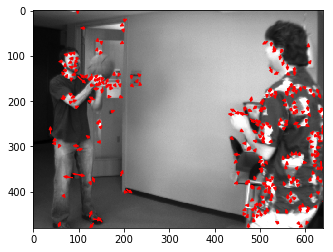

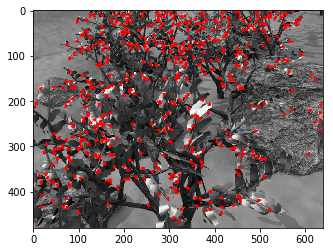

In [9]:
#lucas kanade step will be performed for each of image pairs

for im_iter in range(len(imList1)):

    I1 = Image.open(imList1[im_iter]).convert('L')
    I2 = Image.open(imList2[im_iter]).convert('L')

    A = np.array(I1)
    B = np.array(I2)

    #compute pyramid for image A and image B
    res = calcLK(I2,A,B,halfwindow)

    u = np.zeros((A.shape[0],A.shape[1]))
    v = np.zeros((A.shape[0],A.shape[1]))
    u[:] = res[0]
    v[:] = res[1]

    spacing  = 10
    
    print("A shape is: ",A.shape)
    print("U shape is: ",u.shape)
    print("V shape is: ",v.shape)

    Y, X = np.mgrid[0:A.shape[0], 0:A.shape[1]]

    plt.figure(im_iter*2+0)
    plt.imshow(I1)
    plt.gray()

    #plotting optical flow in image 1
    for i in range(0,u.shape[0]):
        for j in range(0,u.shape[1]):
            if(u[i][j]!=0.0 or v[i][j]!=0.0):
                plt.arrow(j,i,u[i][j],v[i][j],color = 'red',head_width = 6,head_length = 7)


plt.show()
